# Ejercicio 1

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import pandas as pd

## Task 1 - Prepatación del Conjunto de Datos

In [2]:
iris = load_iris()

X = iris.data
y = iris.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Task 2 - Arquitectura modelo

In [3]:
class SimpleFeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.0):
        super(SimpleFeedforwardNN, self).__init__()
        
        #layers
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.hidden_layer1 = nn.Linear(hidden_size1, hidden_size2)
        self.hidden_layer2 = nn.Linear(hidden_size2, output_size)

        #dropout
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        #relu activation function for input layer
        x = F.relu(self.input_layer(x))

        x = self.dropout(x)
        
        #relu activation function for hidden layer 1
        x = F.relu(self.hidden_layer1(x))

        x = self.dropout(x)
        
        #log softmax activation function for hidden layer 2
        x = F.log_softmax(self.hidden_layer2(x), dim=1)
        
        return x

## Task 3 - Funciones de Pérdida

In [4]:
def one_hot_encode(labels, num_classes):
    return F.one_hot(labels, num_classes).float()

In [5]:
def train_model(model, criterion, optimizer, train_loader, test_loader, epochs=50, loss_name=None, num_classes=3, l1_lambda=0.0):
    train_losses = []
    test_losses = []

    start_time = time.time()

    for _ in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # if loss function is MSELoss, convert labels to one-hot
            if loss_name == 'MSELoss':
                labels = F.one_hot(labels, num_classes).float()

            #compute loss
            loss = criterion(outputs, labels)

            if l1_lambda > 0:
                l1_penalty = sum(torch.sum(torch.abs(param)) for param in model.parameters())
                loss += l1_lambda * l1_penalty

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Evaluate the model on the test set
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)

                # if loss function is MSELoss, convert labels to one-hot
                if loss_name == 'MSELoss':
                    labels = F.one_hot(labels, num_classes).float()

                loss = criterion(outputs, labels)

                if l1_lambda > 0:
                    l1_penalty = sum(torch.sum(torch.abs(param)) for param in model.parameters())
                    loss += l1_lambda * l1_penalty

                test_loss += loss.item()

        test_losses.append(test_loss / len(test_loader))

    training_time = time.time() - start_time

    return train_losses, test_losses, training_time


In [6]:
#Converting the data into tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [7]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [8]:
input_size = 4
hidden_size1 = 10
hidden_size2 = 8
output_size = 3

#model
model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size)

In [9]:
# set the different loss functions
loss_functions = {
    'CrossEntropyLoss': nn.CrossEntropyLoss(),
    'MSELoss': nn.MSELoss(),
    'NLLLoss': nn.NLLLoss()
}

#loss records
loss_records = {}

In [10]:
#training the model with different loss functions
for loss_name, criterion in loss_functions.items():
    print(f"Training with {loss_name}...")
    
    # optimizer
    model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # train the model
    train_losses, test_losses, _ = train_model(model, criterion, optimizer, train_loader, test_loader, loss_name=loss_name)
    
    # save the loss records
    loss_records[loss_name] = {
        'train_losses': train_losses,
        'test_losses': test_losses
    }

Training with CrossEntropyLoss...
Training with MSELoss...
Training with NLLLoss...


In [11]:
for loss_name, losses in loss_records.items():
    print(f"Loss function: {loss_name}")
    print(f"Train loss: {losses['train_losses'][-1]:.4f}")
    print(f"Test loss: {losses['test_losses'][-1]:.4f}")
    print()

Loss function: CrossEntropyLoss
Train loss: 0.4129
Test loss: 0.3997

Loss function: MSELoss
Train loss: 2.1943
Test loss: 2.1952

Loss function: NLLLoss
Train loss: 0.3099
Test loss: 0.2664



## Task 4 - Técnicas de Regularización

In [12]:
regularization_techniques = {
    'No Regularization': {'weight_decay': 0.0, 'dropout_rate': 0.0, 'l1_lambda': 0.0},
    'L2 Regularization': {'weight_decay': 0.01, 'dropout_rate': 0.0, 'l1_lambda': 0.0},
    'L1 Regularization': {'weight_decay': 0.0, 'dropout_rate': 0.0, 'l1_lambda': 0.01},
    'Dropout': {'weight_decay': 0.0, 'dropout_rate': 0.5, 'l1_lambda': 0.0},
}

In [13]:
loss_records_regularization = {}

# train the model with different regularization techniques
for reg_name, reg_params in regularization_techniques.items():
    print(f"Training with {reg_name}...")
    
    model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size, dropout_rate=reg_params['dropout_rate'])
    
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=reg_params['weight_decay'])
    
    train_losses, test_losses, _ = train_model(
        model, 
        criterion, 
        optimizer, 
        train_loader, 
        test_loader, 
        epochs=50, 
        loss_name='CrossEntropyLoss',
        l1_lambda=reg_params['l1_lambda']
    )
    
    loss_records_regularization[reg_name] = {
        'train_losses': train_losses,
        'test_losses': test_losses
    }

Training with No Regularization...
Training with L2 Regularization...
Training with L1 Regularization...
Training with Dropout...


In [14]:
for reg_name, losses in loss_records_regularization.items():
    print(f"Regularization technique: {reg_name}")
    print(f"Train loss: {losses['train_losses'][-1]:.4f}")
    print(f"Test loss: {losses['test_losses'][-1]:.4f}")
    print()

Regularization technique: No Regularization
Train loss: 0.2833
Test loss: 0.2423

Regularization technique: L2 Regularization
Train loss: 0.3988
Test loss: 0.3729

Regularization technique: L1 Regularization
Train loss: 0.7379
Test loss: 0.7273

Regularization technique: Dropout
Train loss: 0.6421
Test loss: 0.4325



## Task 5 - Algoritmos de Optimización

In [15]:
optimization_techniques = {
    'SGD': {'optimizer': optim.SGD, 'batch_size': 1, 'params': {'lr': 0.01}},
    'Batch GD': {'optimizer': optim.SGD, 'batch_size': len(train_loader.dataset), 'params': {'lr': 0.01}},
    'Mini-Batch GD': {'optimizer': optim.SGD, 'batch_size': 32, 'params': {'lr': 0.01}},
}

In [16]:
loss_records_optimization = {}

for opt_name, opt_config in optimization_techniques.items():
    print(f"Training with {opt_name}...")
    
    #update the batch size
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=opt_config['batch_size'], shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=opt_config['batch_size'], shuffle=False)
    
    model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size)
    optimizer = opt_config['optimizer'](model.parameters(), **opt_config['params'])
    
    train_losses, test_losses, training_time = train_model(
        model, 
        criterion, 
        optimizer, 
        train_loader, 
        test_loader,
        epochs=50, 
        loss_name='CrossEntropyLoss'
    )
    
    loss_records_optimization[opt_name] = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'training_time': training_time
    }

Training with SGD...
Training with Batch GD...
Training with Mini-Batch GD...


In [17]:
for opt_name, losses in loss_records_optimization.items():
    print(f"Optimization technique: {opt_name}")
    print(f"Train loss: {losses['train_losses'][-1]:.4f}")
    print(f"Test loss: {losses['test_losses'][-1]:.4f}")
    print(f"Training time: {losses['training_time']:.2f} seconds")
    print()

Optimization technique: SGD
Train loss: 0.0554
Test loss: 0.0538
Training time: 4.09 seconds

Optimization technique: Batch GD
Train loss: 1.0990
Test loss: 1.0988
Training time: 0.12 seconds

Optimization technique: Mini-Batch GD
Train loss: 0.9338
Test loss: 0.9036
Training time: 0.24 seconds



## Task 6 - Experimentación y Análisis

In [22]:
mixed_techniques = {  # Different combinations of loss functions, regularization techniques and optimization algorithms
    'CrossEntropyLoss - No Regularization - SGD': {'loss': 'CrossEntropyLoss', 'reg': 'No Regularization', 'opt': 'SGD'},
    'CrossEntropyLoss - No Regularization - Batch GD': {'loss': 'CrossEntropyLoss', 'reg': 'No Regularization', 'opt': 'Batch GD'},
    'CrossEntropyLoss - No Regularization - Mini-Batch GD': {'loss': 'CrossEntropyLoss', 'reg': 'No Regularization', 'opt': 'Mini-Batch GD'},
    'CrossEntropyLoss - L2 Regularization - SGD': {'loss': 'CrossEntropyLoss', 'reg': 'L2 Regularization', 'opt': 'SGD'},
    'CrossEntropyLoss - L2 Regularization - Batch GD': {'loss': 'CrossEntropyLoss', 'reg': 'L2 Regularization', 'opt': 'Batch GD'},
    'CrossEntropyLoss - L2 Regularization - Mini-Batch GD': {'loss': 'CrossEntropyLoss', 'reg': 'L2 Regularization', 'opt': 'Mini-Batch GD'},
    'CrossEntropyLoss - L1 Regularization - SGD': {'loss': 'CrossEntropyLoss', 'reg': 'L1 Regularization', 'opt': 'SGD'},
    'CrossEntropyLoss - L1 Regularization - Batch GD': {'loss': 'CrossEntropyLoss', 'reg': 'L1 Regularization', 'opt': 'Batch GD'},
    'CrossEntropyLoss - L1 Regularization - Mini-Batch GD': {'loss': 'CrossEntropyLoss', 'reg': 'L1 Regularization', 'opt': 'Mini-Batch GD'},
    'CrossEntropyLoss - Dropout - SGD': {'loss': 'CrossEntropyLoss', 'reg': 'Dropout', 'opt': 'SGD'},
    'CrossEntropyLoss - Dropout - Batch GD': {'loss': 'CrossEntropyLoss', 'reg': 'Dropout', 'opt': 'Batch GD'},
    'CrossEntropyLoss - Dropout - Mini-Batch GD': {'loss': 'CrossEntropyLoss', 'reg': 'Dropout', 'opt': 'Mini-Batch GD'},
    'MSELoss - No Regularization - SGD': {'loss': 'MSELoss', 'reg': 'No Regularization', 'opt': 'SGD'},
    'MSELoss - No Regularization - Batch GD': {'loss': 'MSELoss', 'reg': 'No Regularization', 'opt': 'Batch GD'},
    'MSELoss - No Regularization - Mini-Batch GD': {'loss': 'MSELoss', 'reg': 'No Regularization', 'opt': 'Mini-Batch GD'},
    'MSELoss - L2 Regularization - SGD': {'loss': 'MSELoss', 'reg': 'L2 Regularization', 'opt': 'SGD'},
    'MSELoss - L2 Regularization - Batch GD': {'loss': 'MSELoss', 'reg': 'L2 Regularization', 'opt': 'Batch GD'},
    'MSELoss - L2 Regularization - Mini-Batch GD': {'loss': 'MSELoss', 'reg': 'L2 Regularization', 'opt': 'Mini-Batch GD'},
    'MSELoss - L1 Regularization - SGD': {'loss': 'MSELoss', 'reg': 'L1 Regularization', 'opt': 'SGD'},
    'MSELoss - L1 Regularization - Batch GD': {'loss': 'MSELoss', 'reg': 'L1 Regularization', 'opt': 'Batch GD'},
    'MSELoss - L1 Regularization - Mini-Batch GD': {'loss': 'MSELoss', 'reg': 'L1 Regularization', 'opt': 'Mini-Batch GD'},
    'MSELoss - Dropout - SGD': {'loss': 'MSELoss', 'reg': 'Dropout', 'opt': 'SGD'},
    'MSELoss - Dropout - Batch GD': {'loss': 'MSELoss', 'reg': 'Dropout', 'opt': 'Batch GD'},
    'MSELoss - Dropout - Mini-Batch GD': {'loss': 'MSELoss', 'reg': 'Dropout', 'opt': 'Mini-Batch GD'},
    'NLLLoss - No Regularization - SGD': {'loss': 'NLLLoss', 'reg': 'No Regularization', 'opt': 'SGD'},
    'NLLLoss - No Regularization - Batch GD': {'loss': 'NLLLoss', 'reg': 'No Regularization', 'opt': 'Batch GD'},
    'NLLLoss - No Regularization - Mini-Batch GD': {'loss': 'NLLLoss', 'reg': 'No Regularization', 'opt': 'Mini-Batch GD'},
    'NLLLoss - L2 Regularization - SGD': {'loss': 'NLLLoss', 'reg': 'L2 Regularization', 'opt': 'SGD'},
    'NLLLoss - L2 Regularization - Batch GD': {'loss': 'NLLLoss', 'reg': 'L2 Regularization', 'opt': 'Batch GD'},
    'NLLLoss - L2 Regularization - Mini-Batch GD': {'loss': 'NLLLoss', 'reg': 'L2 Regularization', 'opt': 'Mini-Batch GD'},
    'NLLLoss - L1 Regularization - SGD': {'loss': 'NLLLoss', 'reg': 'L1 Regularization', 'opt': 'SGD'},
    'NLLLoss - L1 Regularization - Batch GD': {'loss': 'NLLLoss', 'reg': 'L1 Regularization', 'opt': 'Batch GD'},
    'NLLLoss - L1 Regularization - Mini-Batch GD': {'loss': 'NLLLoss', 'reg': 'L1 Regularization', 'opt': 'Mini-Batch GD'},
    'NLLLoss - Dropout - SGD': {'loss': 'NLLLoss', 'reg': 'Dropout', 'opt': 'SGD'},
    'NLLLoss - Dropout - Batch GD': {'loss': 'NLLLoss', 'reg': 'Dropout', 'opt': 'Batch GD'},
    'NLLLoss - Dropout - Mini-Batch GD': {'loss': 'NLLLoss', 'reg': 'Dropout', 'opt': 'Mini-Batch GD'},
}

In [23]:
def get_metrics(model, test_loader):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    return y_true, y_pred

def get_metrics_report(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return accuracy, precision, recall, f1

In [24]:
mixed_techniques_records = {}

### Entrenamiento

In [25]:
for technique_name, technique_params in mixed_techniques.items():
    print(f"Training with {technique_name}...")
    
    # loss function
    criterion = loss_functions[technique_params['loss']]
    
    # regularization technique
    reg_params = regularization_techniques[technique_params['reg']]
    
    # optimizer
    opt_config = optimization_techniques[technique_params['opt']]
    
    # update the batch size
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=opt_config['batch_size'], shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=opt_config['batch_size'], shuffle=False)
    
    model = SimpleFeedforwardNN(input_size, hidden_size1, hidden_size2, output_size, dropout_rate=reg_params['dropout_rate'])
    optimizer = opt_config['optimizer'](model.parameters(), **opt_config['params'])
    
    train_losses, test_losses, _ = train_model(
        model, 
        criterion, 
        optimizer, 
        train_loader, 
        test_loader, 
        epochs=50, 
        loss_name=technique_params['loss'],
        l1_lambda=reg_params['l1_lambda']
    )
    
    y_true, y_pred = get_metrics(model, test_loader)
    accuracy, precision, recall, f1 = get_metrics_report(y_true, y_pred)
    
    mixed_techniques_records[technique_name] = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

Training with CrossEntropyLoss - No Regularization - SGD...
Training with CrossEntropyLoss - No Regularization - Batch GD...


/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training with CrossEntropyLoss - No Regularization - Mini-Batch GD...


/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training with CrossEntropyLoss - L2 Regularization - SGD...
Training with CrossEntropyLoss - L2 Regularization - Batch GD...
Training with CrossEntropyLoss - L2 Regularization - Mini-Batch GD...


/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training with CrossEntropyLoss - L1 Regularization - SGD...
Training with CrossEntropyLoss - L1 Regularization - Batch GD...
Training with CrossEntropyLoss - L1 Regularization - Mini-Batch GD...


/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training with CrossEntropyLoss - Dropout - SGD...
Training with CrossEntropyLoss - Dropout - Batch GD...
Training with CrossEntropyLoss - Dropout - Mini-Batch GD...


/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training with MSELoss - No Regularization - SGD...
Training with MSELoss - No Regularization - Batch GD...
Training with MSELoss - No Regularization - Mini-Batch GD...
Training with MSELoss - L2 Regularization - SGD...
Training with MSELoss - L2 Regularization - Batch GD...
Training with MSELoss - L2 Regularization - Mini-Batch GD...
Training with MSELoss - L1 Regularization - SGD...


/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training with MSELoss - L1 Regularization - Batch GD...
Training with MSELoss - L1 Regularization - Mini-Batch GD...
Training with MSELoss - Dropout - SGD...
Training with MSELoss - Dropout - Batch GD...


/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training with MSELoss - Dropout - Mini-Batch GD...
Training with NLLLoss - No Regularization - SGD...
Training with NLLLoss - No Regularization - Batch GD...
Training with NLLLoss - No Regularization - Mini-Batch GD...


/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training with NLLLoss - L2 Regularization - SGD...
Training with NLLLoss - L2 Regularization - Batch GD...
Training with NLLLoss - L2 Regularization - Mini-Batch GD...


/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training with NLLLoss - L1 Regularization - SGD...
Training with NLLLoss - L1 Regularization - Batch GD...
Training with NLLLoss - L1 Regularization - Mini-Batch GD...


/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training with NLLLoss - Dropout - SGD...
Training with NLLLoss - Dropout - Batch GD...
Training with NLLLoss - Dropout - Mini-Batch GD...


/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Curvas de Pérdida

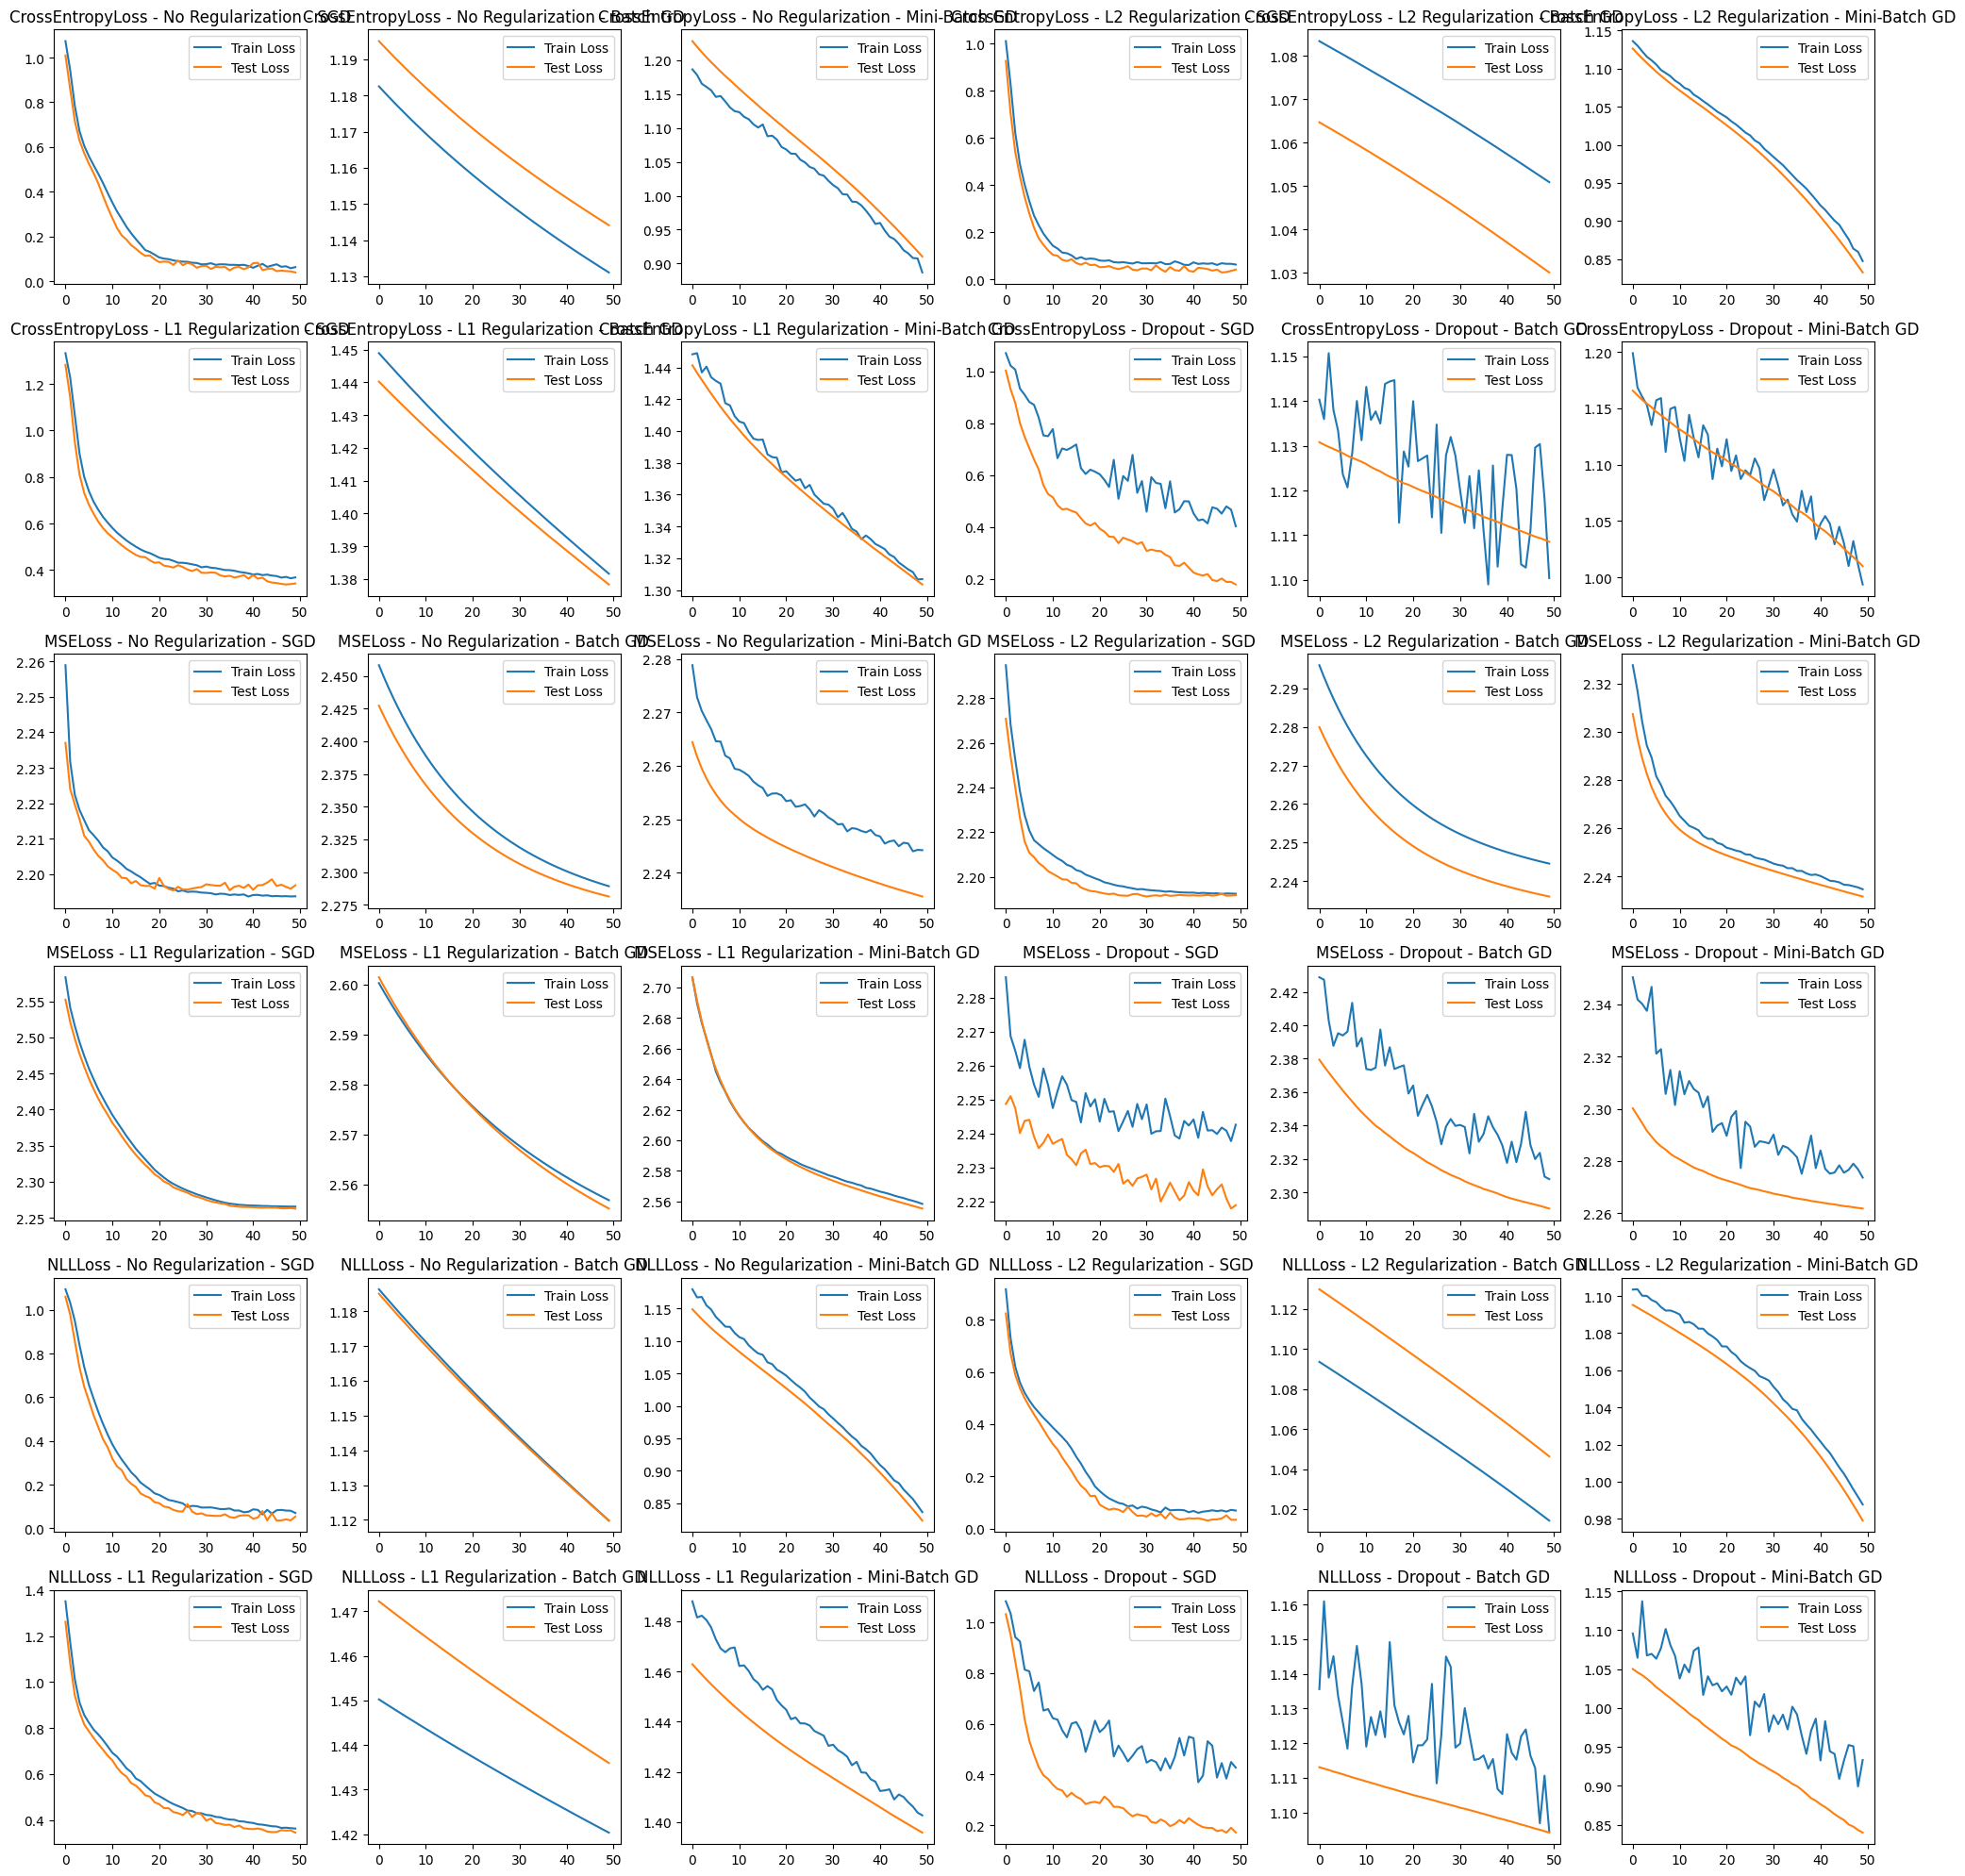

In [27]:
fig, axs = plt.subplots(6, 6, figsize=(20, 20))
axs = axs.ravel()

for i, (technique_name, records) in enumerate(mixed_techniques_records.items()):
    axs[i].plot(records['train_losses'], label='Train Loss')
    axs[i].plot(records['test_losses'], label='Test Loss')
    axs[i].set_title(technique_name)
    axs[i].legend()
    
plt.tight_layout()
plt.show()

### Métricas de Desempeño

In [29]:
# Create a table with the performance metrics
metrics_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1'])

for technique_name, records in mixed_techniques_records.items():
    metrics_df.loc[technique_name] = [records['accuracy'], records['precision'], records['recall'], records['f1']]
    
metrics_df = metrics_df.sort_values(by=['Accuracy', 'Precision', 'Recall', 'F1'], ascending=False)

metrics_df

,Accuracy,Precision,Recall,F1
CrossEntropyLoss - No Regularization - SGD,1.000000,1.000000,1.000000,1.000000
NLLLoss - L2 Regularization - SGD,1.000000,1.000000,1.000000,1.000000
NLLLoss - Dropout - SGD,1.000000,1.000000,1.000000,1.000000
CrossEntropyLoss - L2 Regularization - SGD,0.966667,0.972222,0.962963,0.965899
CrossEntropyLoss - L1 Regularization - SGD,0.966667,0.972222,0.962963,0.965899
CrossEntropyLoss - Dropout - SGD,0.966667,0.972222,0.962963,0.965899
MSELoss - No Regularization - SGD,0.966667,0.972222,0.962963,0.965899
MSELoss - L2 Regularization - SGD,0.966667,0.972222,0.962963,0.965899
NLLLoss - No Regularization - SGD,0.966667,0.972222,0.962963,0.965899
NLLLoss - L1 Regularization - SGD,0.966667,0.972222,0.962963,0.965899


## Task 7 - Discusión
Podemos observar que las diferentes combinaciones nos dan todo tipo de resultados, underfitted, overfitted, y bien ajustados. El tiempo de entrenamiento no fue un factor determinante, pues todos los modelos tardaron menos de 1 segundo en entrenarse. En cuanto a lo que son las métricas de desempeño se puede observar que reflejan la curvas de pérdida y se pueden observar ciertas tendencias en cuanto a la elección de las técnicas de regularización y optimización. 

En general, se puede observar que 11 de 12 (91.66%) modelos que utilizaron la técnica de optimización `SGD` se encuentran en la cima de la puntuación; sin embargo, la gran mayoría se encuentran con overfitting. Posteriormente, los resultados con un ajuste muy bueno (y si tuviéramos que escoger uno, sería entre estos), utilizaron la técnica de `Mini-batch GD`, obteniendo excelentes puntajes a través de las cuatro métricas. Se puede concluir que la técnica de optimización es el factor más influyente en el proceso de entrenamiento de estos modelos.

El segundo factor que más influyó en el desempeño de los modelos fue la técnica de regularización. Se puede observar que los modelos que utilizaron la técnica de `L2` obtuvieron los mejores resultados en cuanto a las métricas de desempeño, seguidos por los modelos que no utilizaron técnicas de regularización. Por otro lado, los modelos que utilizaron la técnica de `L1` y `Drop out` obtuvieron resultados similares, pero en general, un poco peores que los modelos que utilizaron las otras técnicas de regularización.

Los resultados en cuanto a las funciones de pérdida no fueron tan claros, es complicado determinar que tipo de función es la que produjo mejores resultados. Si nos guiamos por lo que se mostró en las métricas de desempeño, la función de pérdida `CrossEntropyLoss` y `NLLLoss` obtuvieron mejores resultados que la función de pérdida `MSELoss`. Sin embargo, no se puede determinar con certeza que una función de pérdida sea mejor que otra, ya que los resultados varían dependiendo de las técnicas de regularización y optimización utilizadas.

# Ejercicio 2

1. ¿Cuál es la principal innovación de la arquitectura Transformer?

A diferencia de los modelos RNN o CNN, los cuales usaban una artquitectura de encoder-decoder y tienen muchas limitantes de rendimiento y dependencia, la arquitectura transformer busca obtener una atención mayor al contexto dado por medio del Self-Attention. Esto permite que todas las posiciones o tokens de la secuencia puedan atender a cualquier otra posición de la misma, obteniendo así un mejor alcance y mayor comprensión del contexto. Esto permite que sea altamente paralelizadle, por lo que este tipo de arquitecturas proveen una mayor eficiencia computacional.

2. ¿Cómo funciona el mecanismo de atención del scaled dot-product?

Este mecanismo funciona por medio de tres matrices de entrada: Kyes, Values y Queries. Dadas estas matrices, se obtiene el producto punto de Queries y de Keys, para luego dividirlo entre la raíz cuadrada de la dimensionalidad de Keys. Luego de aplicar softmax al resultado, se obtiene un conjunto de ponderaciones que, combinadas con su respectivo Values, devuelve un vector el cual indica la importancia o relevancia de cada Value.

3. ¿Por qué se utiliza la atención de múltiples cabezales en Transformer?

La razón de utilizar múltiples cabezales para la atención es debido a que, de esta forma es posible paralelizar diferentes perspectivas de el mismo conjunto de información. Debido a este tipo de arquitectura, los transformers pueden explorar diferentes perspectivas de la información al mismo tiempo. 

4. ¿Cómo se incorporan los positional encodings en el modelo Transformer?
5. ¿Cuáles son algunas aplicaciones de la arquitectura Transformer más allá de la machine translation?